In [1]:
import random

random_seed = 10
random.seed(random_seed)

In [2]:
!pip install plsa
!pip install gensim

In [3]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import nltk

from gensim import corpora
from gensim.models import TfidfModel

from plsa import Corpus, Pipeline, Visualize
from plsa.pipeline import DEFAULT_PIPELINE
from plsa.algorithms import PLSA

In [5]:
%matplotlib inline
plt.style.use('fivethirtyeight')
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [6]:
# Code partially sourced from: https://github.com/yedivanseven/PLSA/blob/master/notebooks/Examples.ipynb
# Documentation: https://probabilistic-latent-semantic-analysis.readthedocs.io/en/latest/

from google.colab import drive
drive.mount('/content/gdrive')

#grievances_df = pd.read_csv('/content/gdrive/MyDrive/DSSI/Palm_Oil_Grievances/Data/palm_oil_grievance_logs.csv')

#shared drive version at everyone can set up
grievances_df = pd.read_csv('/content/gdrive/MyDrive/Group 3: palm oil topic classifier/Data/palm_oil_grievance_logs.csv')
grievances_df.head(5)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


,pk,source,internal_id,status,submitted_on,accepted_on,last_updated_on,country,region,complainants,respondents,respondent_sector,respondent_parent_company,respondent_supplier,summary,history,external_link,extras
0,1,Roundtable on Sustainable Palm Oil (RSPO),500Mg00000L0di6IAB,Closed,2/26/2025,4/15/2025,5/20/2025,Indonesia,Sumatera Selatan,Confidential,PT Sawit Mas Sejahtera,Oil Palm Growers,Golden Agri-Resources (GAR),NaN,That the Respondent allegedly transferred the ...,2025-05-20: CP's Decision Letter dated 20. 05....,https://rspo.my.site.com/Complaint/s/case/500M...,{'case_number': 'RSPO/2025/02/RR'}
1,2,Roundtable on Sustainable Palm Oil (RSPO),500GB00003xVwYqYAK,In Progress - Investigation,11/29/2024,1/16/2025,1/16/2025,Mexico,NaN,Confidential,INDUSTRIAS OLEOPALMA S.A. DE C.V.,Oil Palm Growers,Oleoquímica Mexicana S.A. de C.V.,NaN,The Complainant alleges that the Respondent ha...,2025-04-30: The Secretariat furnished the Resp...,https://rspo.my.site.com/Complaint/s/case/500G...,{'case_number': 'RSPO/2024/17/MAM'}
2,3,Roundtable on Sustainable Palm Oil (RSPO),500GB00003xVxmPYAS,In Progress - Investigation,11/28/2024,1/21/2025,1/21/2025,Colombia,Montes de María,Confidential,OLEOFLORES S A S,Processors and/or Traders,Musim Mas Holdings Pte.,NaN,1.The Complainant alleges that the Respondent ...,2025-04-30: The Complaints Panels directive to...,https://rspo.my.site.com/Complaint/s/case/500G...,{'case_number': 'RSPO/2024/18/HN'}
3,4,Roundtable on Sustainable Palm Oil (RSPO),500GB00003xVGg2YAG,In Progress - Investigation,10/16/2024,11/18/2024,11/18/2024,Indonesia,Riau,S. Samsul Hadi,PT Guntung Idamannusa,Oil Palm Growers,Compañía Industrial Aceitera Coto Cincuenta y ...,NaN,The Respondent's Corporate Social Responsibili...,2025-04-30: The Complaints Panel has directed ...,https://rspo.my.site.com/Complaint/s/case/500G...,{'case_number': 'RSPO/2024/14/RH'}
4,5,Roundtable on Sustainable Palm Oil (RSPO),500GB00003vMwFgYAK,In Progress - Investigation,9/11/2024,10/29/2024,10/29/2024,Costa Rica,Pococi/Limón,Confidential,Compañía Palma Tica S.A.,Oil Palm Growers,NaN,NaN,The Complainant alleges that the Respondent br...,2025-04-30: The Briefing Note is in progress. ...,https://rspo.my.site.com/Complaint/s/case/500G...,{'case_number': 'RSPO/2024/13/MAM'}


# LSA Model Creation Functions

In [10]:
print(f"Original documents: {len(grievances_df)}")

# --- Extract summary column ---
document_list = grievances_df['summary'].dropna().tolist()
print(f"Documents after dropping NA: {len(document_list)}")

Original documents: 430
Documents after dropping NA: 387


## preprocess_data

In [13]:
stopwords_extra = ['pt','report','rspo','alleged', 'palm', 'oil', 'company', 'community', 'complainant',
                   'companies', 'also', 'without', 'group', 'allegedly', 'period', 'respondent', 'reported',
                   'mentioned', '2019', '19', '2020', 'subsidary', 'alleges']

stop = set(stopwords.words('english') + stopwords_extra)


def remove_stopwords(tokens):
    return [token for token in tokens if token.lower() not in stop]

# --- Preprocessing function ---
def preprocess_data(doc_set):
    tokenizer = RegexpTokenizer(r'\w+')
    p_stemmer = PorterStemmer()
    texts = []

    for doc in doc_set:
        raw = doc.lower()
        tokens = tokenizer.tokenize(raw)
        stopped_tokens = [token for token in tokens if token not in stop]
        stemmed_tokens = [p_stemmer.stem(token) for token in stopped_tokens]
        texts.append(stemmed_tokens)

    return texts

clean_text = preprocess_data(document_list)
print(f"Cleaned documents: {len(clean_text)}")

Cleaned documents: 387


In [47]:
#Setup plsa pipeline

custom_pipeline = [step for step in DEFAULT_PIPELINE if step.__class__.__name__ != "LemmatizeWords"]
pipeline = Pipeline(*custom_pipeline, remove_stopwords)

In [48]:
#Save cleaned summaries to CSV for PLSA corpus
cleaned_summaries_for_csv = [" ".join(doc) for doc in clean_text]
pd.DataFrame(cleaned_summaries_for_csv, columns=['summary']).to_csv('summary.csv', index=False)


In [49]:
#Create Corpus from CSV
corpus = Corpus.from_csv('summary.csv', pipeline)
print(f"Number of documents in corpus: {corpus.n_docs}")


Number of documents in corpus: 387


In [50]:
#Fit PLSA
n_topics = 7
plsa = PLSA(corpus, n_topics, True)
print("PLSA training completed.")

PLSA training completed.


In [51]:
result = plsa.best_of(2)
result

PlsaResult:
Number of topics:    7
Number of documents: 387
Number of words:     2842

In [65]:
def format_topics_sentences(model, texts):
    doc_topic = model.topic_given_doc  # shape: (n_docs, n_topics)
    rows = []
    for i, topic_dist in enumerate(doc_topic):
        dominant_topic = np.argmax(topic_dist)
        topic_contribution = topic_dist[dominant_topic]
        rows.append((i, dominant_topic, topic_contribution, texts[i]))
    return pd.DataFrame(rows, columns=['Document_No', 'Dominant_Topic', 'Topic_Perc_Contribution', 'Text'])


In [66]:
dominant_topic_df = format_topics_sentences(result, document_list)
print(dominant_topic_df['Dominant_Topic'].value_counts())


Dominant_Topic
2    87
1    75
5    48
0    48
3    46
6    42
4    41
Name: count, dtype: int64


In [67]:
dominant_topic_df.to_csv("pLSA_results.csv", index=False)

In [72]:
dominant_topic_df[dominant_topic_df['Dominant_Topic'] == 5]

,Document_No,Dominant_Topic,Topic_Perc_Contribution,Text
4,4,5,0.455967,The Complainant alleges that the Respondent br...
9,9,5,1.000000,Allegations raised against the Respondent are ...
18,18,5,1.000000,Decrease of the number of workers in a union d...
20,20,5,0.628809,Allegations made against the Respondent are in...
21,21,5,1.000000,Pertaining to labour related issues such as wa...
22,22,5,1.000000,Allegations made against the Respondent are pe...
39,39,5,1.000000,The daily casual workers are paid below the mi...
41,41,5,0.815761,Unilateral pay cut by the Respondent; Poor liv...
43,43,5,0.461224,Non-compliance with labour rights/laws; Anti-u...
45,45,5,1.000000,Unauthorised Company Regulation; Flat rate ove...


# Visualization

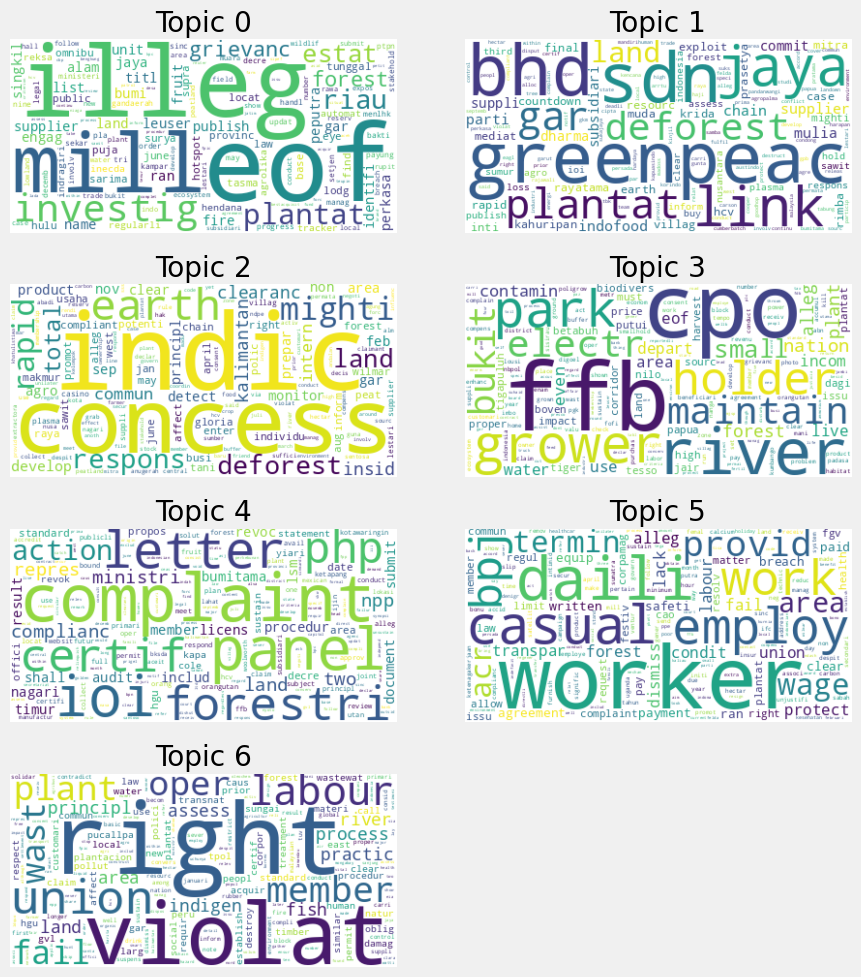

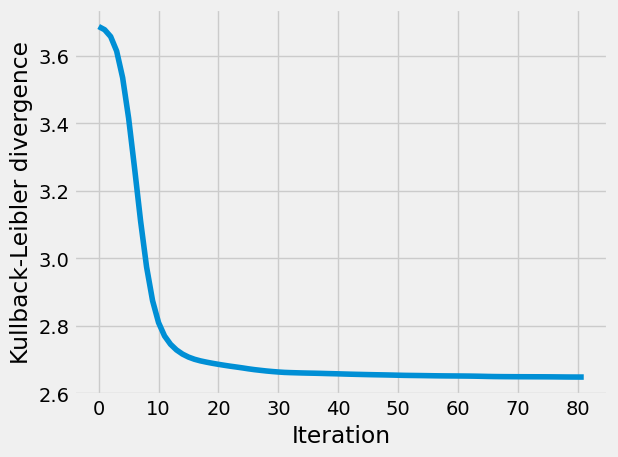

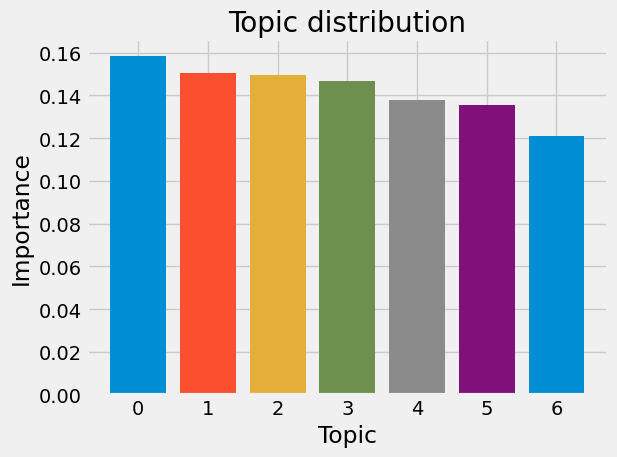

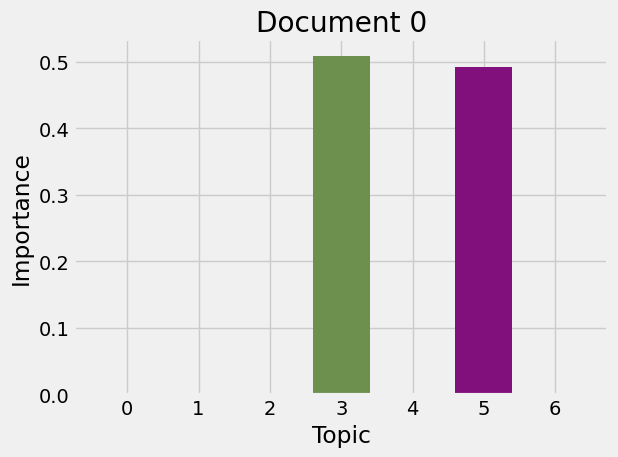

In [61]:
# --- Visualization ---
visualize = Visualize(result)

fig = plt.figure(figsize=(9.4, 10))
_ = visualize.wordclouds(fig)

fig, ax = plt.subplots()
_ = visualize.convergence(ax)
fig.tight_layout()

fig, ax = plt.subplots()
_ = visualize.topics(ax)
fig.tight_layout()

fig, ax = plt.subplots()
_ = visualize.topics_in_doc(0, ax)  # visualize first document's topic distribution
fig.tight_layout()

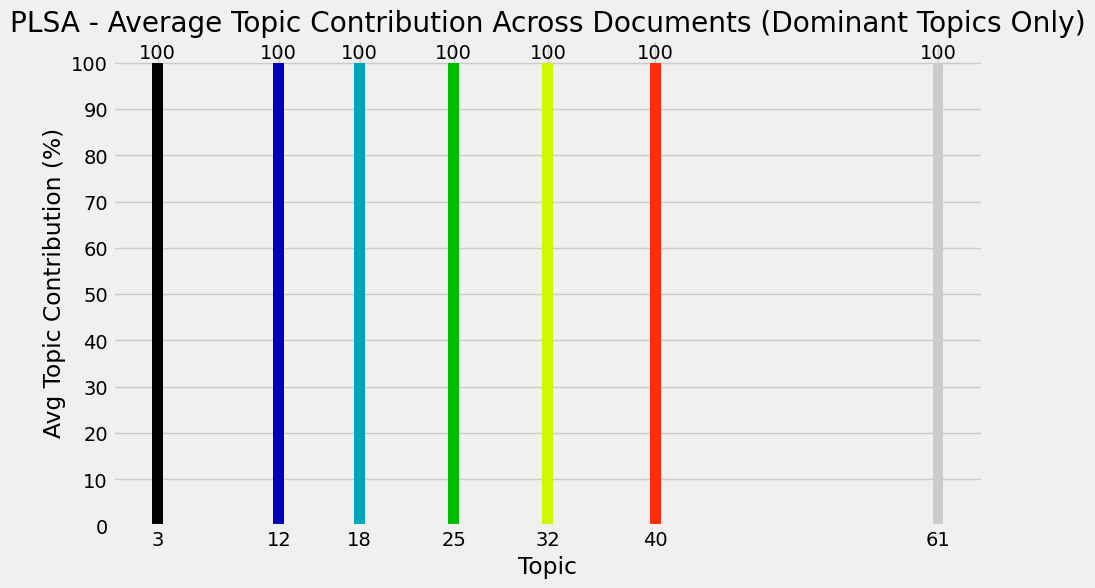

In [62]:
# Average topic contribution across documents (dominant topics only)
topic_avg_df = dominant_topic_df.groupby('Dominant_Topic')['Topic_Perc_Contribution'].mean().reset_index()
indexes = topic_avg_df['Dominant_Topic']
values = topic_avg_df['Topic_Perc_Contribution'].round(1)
colors = plt.cm.nipy_spectral(np.linspace(0, 1, len(indexes)))

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(indexes, values, color=colors[:len(indexes)])
ax.bar_label(bars)
ax.set_title(f'PLSA - Average Topic Contribution Across Documents (Dominant Topics Only)')
ax.set_xlabel('Topic')
ax.set_ylabel('Avg Topic Contribution (%)')
plt.xticks(indexes)
plt.yticks(range(0, 101, 10))
plt.show()


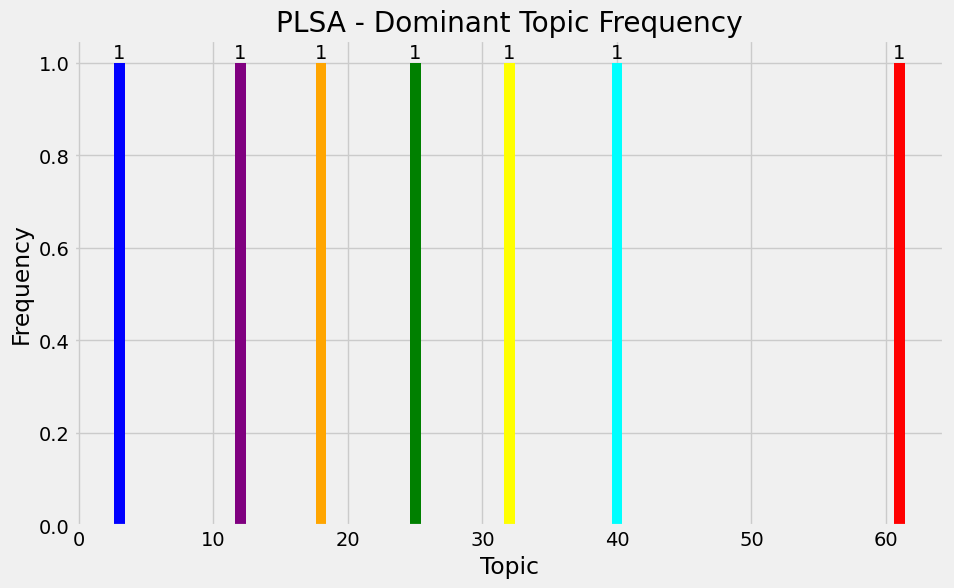

In [63]:
# Frequency of dominant topics
topics_df = dominant_topic_df['Dominant_Topic'].value_counts().reset_index()
topics_df.columns = ['Dominant_Topic', 'Frequency']
colors_7 = ['red', 'blue', 'yellow', 'green', 'purple', 'orange', 'cyan']

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(topics_df['Dominant_Topic'], topics_df['Frequency'], color=colors_7[:len(topics_df)])
ax.bar_label(bars)
ax.set_title(f'PLSA - Dominant Topic Frequency')
ax.set_xlabel('Topic')
ax.set_ylabel('Frequency')
plt.show()

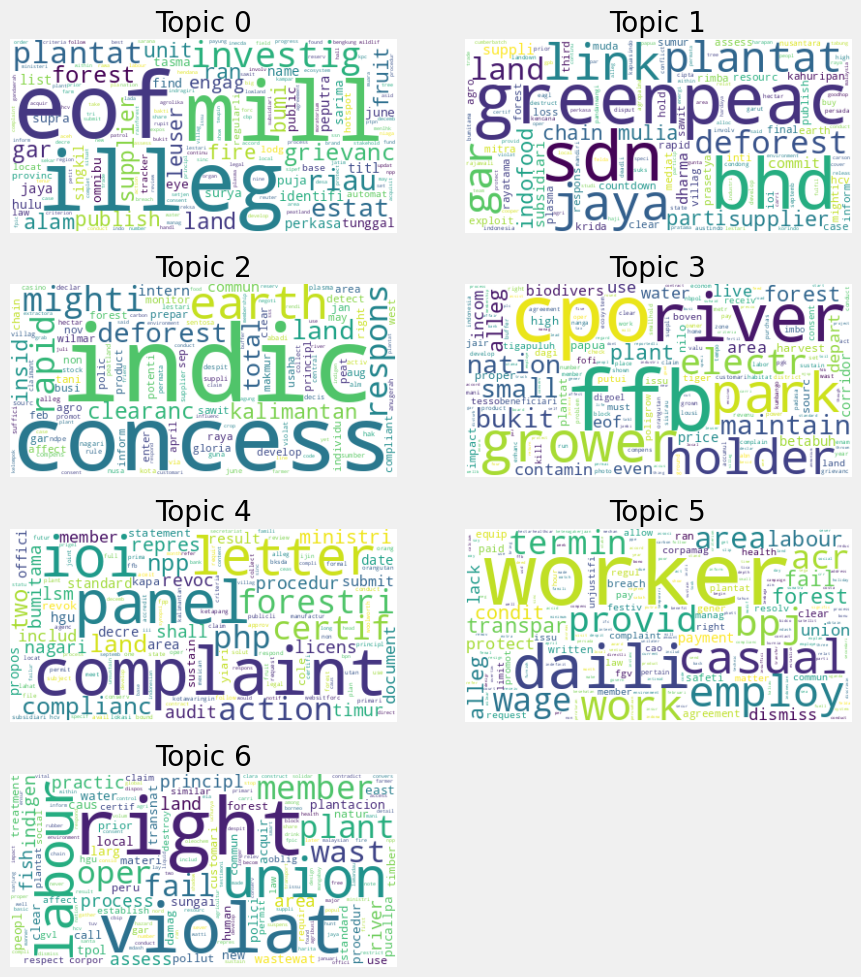

In [64]:
visualize = Visualize(result)
visualize

fig = plt.figure(figsize=(9.4, 10))
_ = visualize.wordclouds(fig)

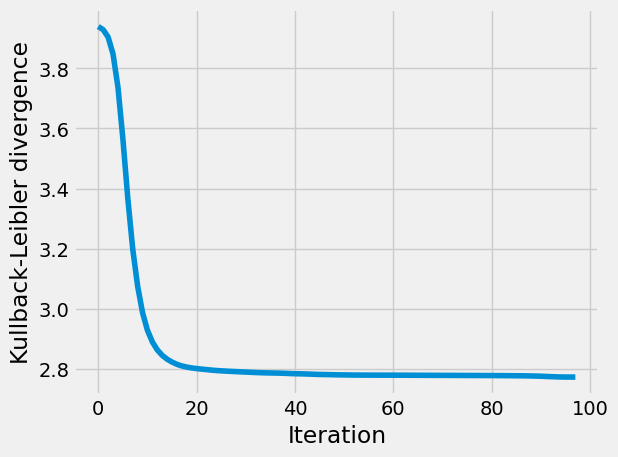

In [19]:
# this divergence measures how much information is lost when using Q to approximate P.

fig, ax = plt.subplots()
_ = visualize.convergence(ax)
fig.tight_layout()

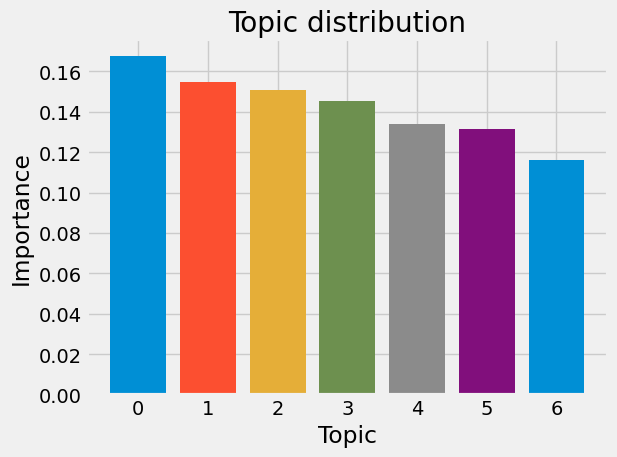

In [20]:
fig, ax = plt.subplots()
_ = visualize.topics(ax)
fig.tight_layout()

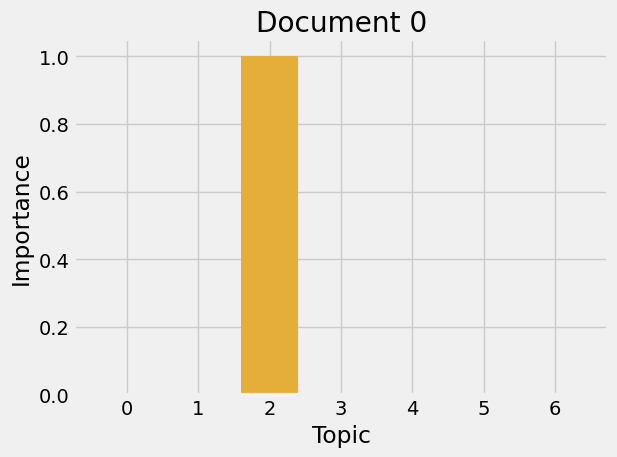

In [21]:
fig, ax = plt.subplots()
_ = visualize.topics_in_doc(0, ax) # change int to change doc
fig.tight_layout()

In [22]:
result.topic_given_doc[2]

array([0., 1., 0., 0., 0., 0., 0.])

## creating the data frame

In [23]:
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus, converting list of documents (corpus) into Document Term Matrix,
             and applying TF-IDF weighting.
    Output : term dictionary, TF-IDF weighted Document Term Matrix, and TF-IDF model
    """
    # Creating the term dictionary of our corpus, where every unique term is assigned an index.
    dictionary = corpora.Dictionary(doc_clean)

    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

    # Applying TF-IDF weighting
    tfidf_model = TfidfModel(doc_term_matrix)
    tfidf_matrix = tfidf_model[doc_term_matrix]

    # generate LDA model
    return dictionary, tfidf_matrix, tfidf_model

In [24]:
import numpy as np
import pandas as pd

def format_topics_sentences(model, texts):
    doc_topic = model._doc_given_topic.T  # shape: (n_docs, n_topics)

    rows = []
    for i, topic_dist in enumerate(doc_topic):
        dominant_topic = np.argmax(topic_dist)
        topic_contribution = topic_dist[dominant_topic]
        rows.append((i, dominant_topic, topic_contribution, texts[i]))

    return pd.DataFrame(rows, columns=['Document_No', 'Dominant_Topic', 'Topic_Perc_Contribution', 'Text'])



In [25]:
document_list, titles = load_data_from_dataframe(grievances_df['summary'])
clean_text = preprocess_data(document_list)
document_list

Total Number of Documents: 387
That the Respondent allegedly transferred the Complainant to a different department purportedly as punishment for providing information to the auditors during the Respondents audit period.The Complainant alleges that he is made to work extra hours and his wages do not commensurate with his work load.
The Complainant alleges that the Respondent has unjustifiably dismissed workers, deceiving them into resigning with the promise that they will be rehired;It is alleged that the Respondent did not pay the dismissed workers the full amount of compensation for early termination of contract, breaching Mexican federal labour law;The Respondent bribed the authorities to obtain the parcel certificate from the National Agrarian Registry (RAN) required by Mexican Law;It is alleged that the Respondent has falsified information regarding land ownership in order to use it as evidence to avoid the imposition of non-conformities during audits; andThe Complainant alleges th

['That the Respondent allegedly transferred the Complainant to a different department purportedly as punishment for providing information to the auditors during the Respondents audit period.The Complainant alleges that he is made to work extra hours and his wages do not commensurate with his work load.',
 'The Complainant alleges that the Respondent has unjustifiably dismissed workers, deceiving them into resigning with the promise that they will be rehired;It is alleged that the Respondent did not pay the dismissed workers the full amount of compensation for early termination of contract, breaching Mexican federal labour law;The Respondent bribed the authorities to obtain the parcel certificate from the National Agrarian Registry (RAN) required by Mexican Law;It is alleged that the Respondent has falsified information regarding land ownership in order to use it as evidence to avoid the imposition of non-conformities during audits; andThe Complainant alleges that crude oil palm is stor

In [26]:
dir(plsa)

['_BasePLSA__e_step',
 '_BasePLSA__n_topics',
 '_BasePLSA__negative_entropy',
 '_BasePLSA__norm',
 '_BasePLSA__normalize',
 '_BasePLSA__random',
 '_BasePLSA__rel_change',
 '_BasePLSA__tf_idf',
 '_BasePLSA__validated',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_conditional',
 '_corpus',
 '_doc_given_topic',
 '_doc_word',
 '_invert',
 '_joint',
 '_kl_divergences',
 '_m_step',
 '_norm_sum',
 '_result',
 '_topic',
 '_word_given_topic',
 'best_of',
 'fit',
 'n_topics',
 'tf_idf']

In [27]:
# Grab TFIDF matrix from prev functions
_ , tfidf_matrix , _ = prepare_corpus(clean_text)

# Format
dominant_topic_df = format_topics_sentences(model=plsa, texts=document_list).reset_index()
dominant_topic_df.head(10)

,index,Document_No,Dominant_Topic,Topic_Perc_Contribution,Text
0,0,0,113,0.244143,That the Respondent allegedly transferred the ...
1,1,1,128,0.079418,The Complainant alleges that the Respondent ha...
2,2,2,178,0.041579,1.The Complainant alleges that the Respondent ...
3,3,3,115,0.119836,The Respondent's Corporate Social Responsibili...
4,4,4,134,0.146156,The Complainant alleges that the Respondent br...
5,5,5,117,0.356541,1. The Complainant alleges that he informed th...
6,6,6,54,0.104734,The Respondent has allegedly conducted land cl...


In [28]:
# Convert to CSV and save
dominant_topic_df.to_csv("pLSA_results.csv",index = False)
from google.colab import files
# files.download("LSA_results.csv")

In [29]:
dominant_topic_df[dominant_topic_df['Dominant_Topic'] == 2]

,index,Document_No,Dominant_Topic,Topic_Perc_Contribution,Text


In [30]:
dominant_topic_df = format_topics_sentences(model=plsa, texts=document_list)
print(dominant_topic_df['Dominant_Topic'].value_counts())


Dominant_Topic
113    1
128    1
178    1
115    1
134    1
117    1
54     1
Name: count, dtype: int64


## Average Dominant Topic Contribution

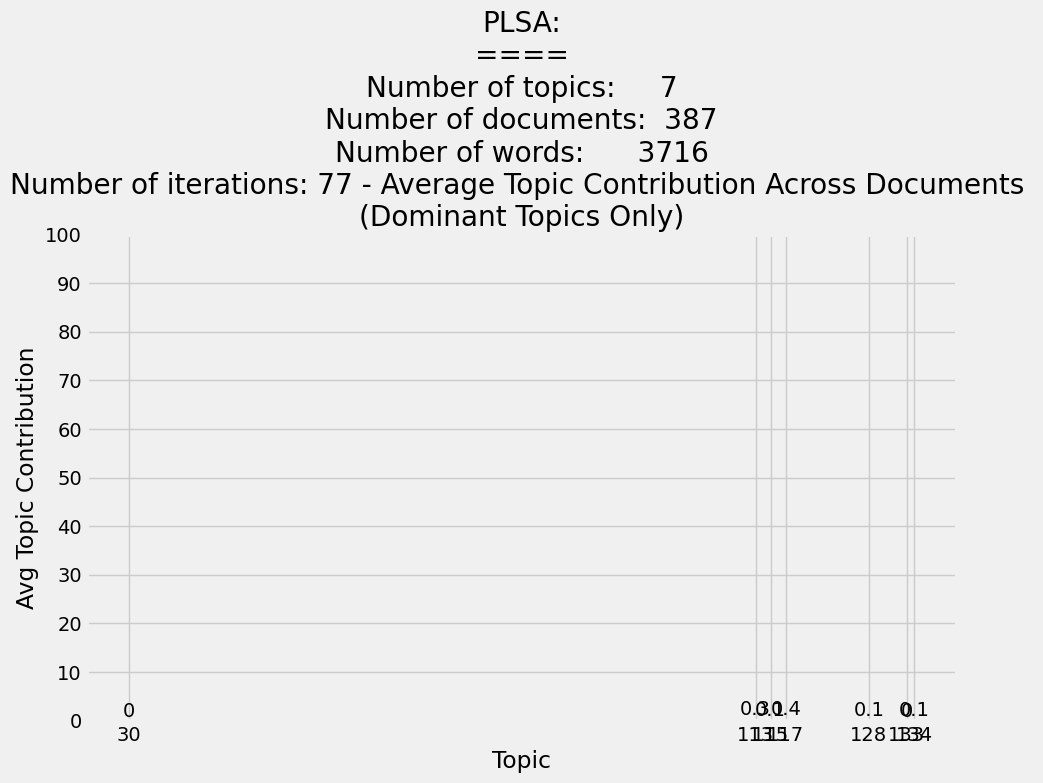

In [31]:
# Prepare data
topic_avg_df = dominant_topic_df.groupby('Dominant_Topic')['Topic_Perc_Contribution'].mean().reset_index()
indexes = topic_avg_df['Dominant_Topic']
values = topic_avg_df['Topic_Perc_Contribution'].round(1)

colors = plt.cm.nipy_spectral(np.linspace(0, 1, len(indexes)))

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(indexes, values, color=colors[:len(indexes)])
ax.bar_label(bars)

# Labels and title
ax.set_title(f'{plsa} - Average Topic Contribution Across Documents \n(Dominant Topics Only)')
ax.set_xlabel('Topic')
ax.set_ylabel('Avg Topic Contribution')
plt.xticks(indexes)
plt.yticks(range(0,101,10))
plt.show()

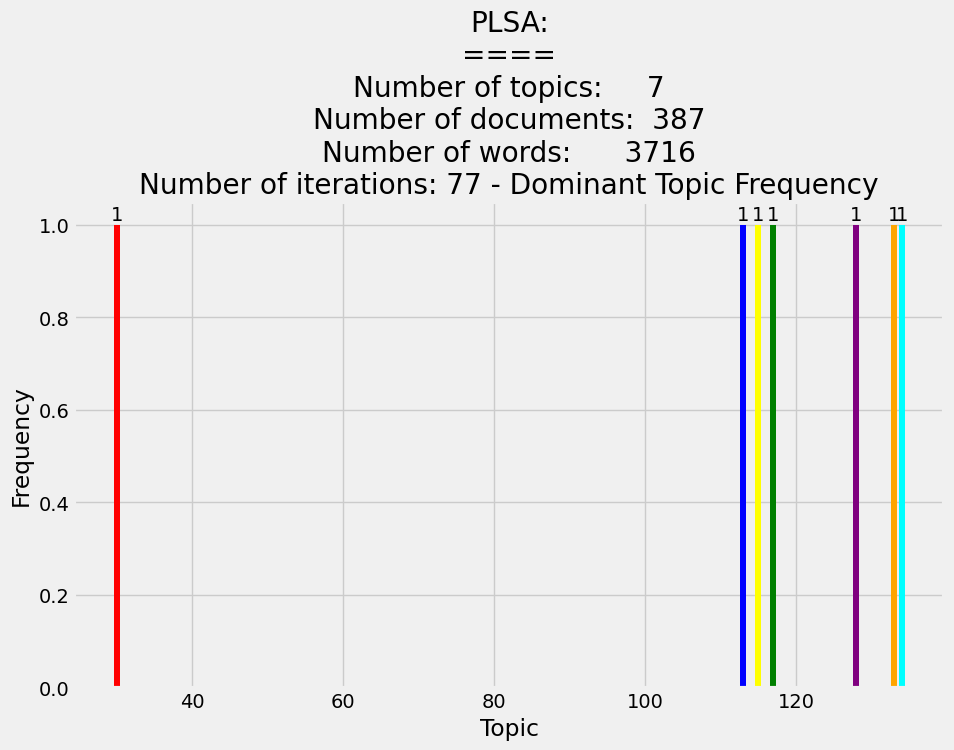

In [33]:
# Prepare data
topics_df = dominant_topic_df.groupby(['Dominant_Topic'])['index'].count().reset_index()
indexes = topics_df['Dominant_Topic']
values = topics_df['index']
colors_7 = ['red', 'blue', 'yellow', 'green', 'purple', 'orange', 'cyan']

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(indexes, values, color=colors_7[:len(indexes)])
ax.bar_label(bars)

# Labels and title
ax.set_title(f'{plsa} - Dominant Topic Frequency')
ax.set_xlabel('Topic')
ax.set_ylabel('Frequency')
plt.show()

In [39]:
print(f"Original docs: {len(document_list)}")
print(f"Cleaned docs: {len(clean_text)}")

Original docs: 387
Cleaned docs: 387


In [40]:
empty_docs = [i for i, doc in enumerate(clean_text) if len(doc) == 0]
print(f"Number of empty documents: {len(empty_docs)}")


Number of empty documents: 0


In [43]:
print(f"Number of documents in corpus: {corpus.n_docs}")


Number of documents in corpus: 387


In [44]:
dominant_topic_df[dominant_topic_df['Dominant_Topic'] == 2]


,index,Document_No,Dominant_Topic,Topic_Perc_Contribution,Text


In [45]:
print(dominant_topic_df['Dominant_Topic'].value_counts())


Dominant_Topic
113    1
30     1
133    1
128    1
115    1
134    1
117    1
Name: count, dtype: int64


In [46]:
print(f"Number of documents passed to PLSA: {len(corpus.documents)}")


AttributeError: 'Corpus' object has no attribute 'documents'

In [47]:
for i, topic_vector in enumerate(plsa.topic_given_doc[:10]):
    print(f"Doc {i}: {topic_vector}")


AttributeError: 'PLSA' object has no attribute 'topic_given_doc'